## Layout routing agent

### Load an image

In [41]:
import base64
from pathlib import Path

def load_image(inputs: dict) -> dict:
    image_path = inputs["image_path"]
    image_data = Path(image_path).read_bytes()
    image_base64 = base64.b64encode(image_data).decode('utf-8')
    return {"image": image_base64}

result = load_image({"image_path": "/Users/maryamsaad/Documents/arabic-ocr-transformer/ttest.png"})
print(result)

{'image': 'iVBORw0KGgoAAAANSUhEUgAABCIAAAY8CAYAAADQki6RAAAMTWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnltSIQQIREBK6E0QkRJASggt9I4gKiEJEEqMCUHFjiyu4NpFBMuKrlIU2wrIYkNddWVR7H2xoKKsi+tiV96EALrsK9+b75s7//3nzD/nnDv3zh0A6F18qTQX1QQgT5Iviw32Z01OTmGRegAZ6AEceAEDvkAu5URHhwNYhtu/l9fXAKJsLzsotf7Z/1+LllAkFwCAREOcLpQL8iD+EQC8VSCV5QNAlELefFa+VInXQawjgw5CXKPEmSrcqsTpKnxx0CY+lgvxIwDI6ny+LBMAjT7IswoEmVCHDqMFThKhWAKxH8Q+eXkzhBAvgtgG2sA56Up9dvpXOpl/00wf0eTzM0ewKpbBQg4Qy6W5/Dn/Zzr+d8nLVQzPYQ2repYsJFYZM8zbo5wZYUqsDvFbSXpkFMTaAKC4WDhor8TMLEVIgsoetRHIuTBngAnxJHluHG+IjxXyA8IgNoQ4Q5IbGT5kU5QhDlLawPyhFeJ8XjzEehDXiOSBcUM2x2UzYofnvZYh43KG+Kd82aAPSv3PipwEjkof084S8Yb0McfCrPgkiKkQBxSIEyMh1oA4Up4TFzZkk1qYxY0ctpEpYpWxWEAsE0mC/VX6WHmGLCh2yL4uTz4cO3Y8S8yLHMKX8rPiQ1S5wh4J+IP+w1iwPpGEkzCsI5JPDh+ORSgKCFTFjpNFkoQ4FY/rSfP9Y1VjcTtpbvSQPe4vyg1W8mYQx8sL4obHFuTDxanSx0uk+dHxKj/xymx+aLTKH3wfCAdcEABYQAFrOpgBsoG4o7epF96peoIAH8hAJhABhyFmeETSYI8EXuNAIfgdIhGQj4zzH+wVgQLIfxrFKjnxCKe6OoCMoT6lSg54DHEeCAO58F4xqCQZ8SARPIKM+B8e8WEVwBhyYVX2/3t+mP3Cc

### Classify model output

In [42]:
from typing import Literal
from pydantic import BaseModel, Field

class PageInformation(BaseModel):
    """Information about the page layout."""
    page_orientation: Literal["single_column", "double_column"] = Field(
        description="Whether the page layout is formatted in a single column or double columns."
    )

#### Model Selection

In [ ]:
from ollama import Client
import os
from langchain_core.runnables import RunnableLambda
from dotenv import load_dotenv
load_dotenv()
client = Client(
    host="https://ollama.com",
    headers={'Authorization': 'Bearer ' + os.getenv("OLLAMA_API") }
)

def call_ollama_vision(input):
    messages = [
        {
            "role": "user",
            "content": input["prompt"],
            "images": [input["image"]],
        }
    ]
    output = ""
    for part in client.chat("qwen3-vl:235b", messages=messages, stream=False):
        output += part["message"]["content"]
    return output

vision_chain = RunnableLambda(call_ollama_vision)

### Orchestrator

In [48]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# Create parser with PageInformation (defined in Cell 4)
parser = JsonOutputParser(pydantic_object=PageInformation)

vision_prompt = PromptTemplate(
    template="""
Look at the document page image provided and determine the page layout.

Analyze the image and classify whether the page has:
- "single_column": Text/content is arranged in a reguler line by line layout.
- "double_column": Text/content is arranged in two columns (side by side).

Respond with a JSON object matching this exact format:
{format_instructions}
""",
    input_variables=[],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)


In [49]:
from langchain_core.runnables import RunnableLambda

def call_ollama(input: dict):
    # For vision models, include the image in the messages
    # Note: The image should be base64 encoded string
    prompt_text = vision_prompt.format_prompt().to_string()
    
    messages = [
        {
            "role": "user",
            "content": prompt_text,
            "images": [input["image"]]  
        }
    ]
    

    response = client.chat("qwen3-vl:235b", messages=messages, stream=False)
    
    # Access the content from the message
    return response.message.content

image_model = RunnableLambda(call_ollama)


In [50]:
from langchain_core.runnables import RunnableLambda

parser_runnable = RunnableLambda(lambda x: parser.parse(x))
vision_chain = image_model | parser_runnable


### Results

In [51]:
image_path = {"image_path": "/Users/maryamsaad/Documents/arabic-ocr-transformer/ttest.png"}
result_dict=load_image(image_path)
result = vision_chain.invoke(result_dict)
print(result)


{'page_orientation': 'double_column'}


In [53]:
image_path = {"image_path": "/Users/maryamsaad/Documents/arabic-ocr-transformer/test6.png"}
result_dict=load_image(image_path)
result = vision_chain.invoke(result_dict)
print(result)

{'page_orientation': 'single_column'}


In [62]:
image_path = {"image_path": "/Users/maryamsaad/Documents/arabic-ocr-transformer/firsttest.png"}
result_dict=load_image(image_path)
result = vision_chain.invoke(result_dict)
print(result)

{'page_orientation': 'double_column'}


### Routing to respected func

In [75]:
import numpy as np
def single_col(bboxes):
    """
    Orders bounding boxes for single column layout (top to bottom).
    Returns ordered list of bboxes in reading order.
    """
    if not bboxes:
        return []
    
    # Sort by y-coordinate (top to bottom)
    ordered = sorted(bboxes, key=lambda b: b.bbox[1])
    return ordered

def two_col(bboxes):
    """
    Groups bounding boxes into two columns (right-to-left order) for Arabic documents.
    Returns ordered list of bboxes in reading order: right column top→bottom, then left column.
    """
    if not bboxes:
        return []

    # Compute horizontal centers
    centers = [((b.bbox[0] + b.bbox[2]) / 2, b) for b in bboxes]
    centers.sort(key=lambda x: x[0])  # sort by x-center (left → right)
    xs = [c[0] for c in centers]

    # Find the largest horizontal gap → column separator
    if len(xs) > 1:
        diffs = np.diff(xs)
        split_idx = np.argmax(diffs) + 1
    else:
        split_idx = 1

    # Divide into left and right columns
    left_col = [c[1] for c in centers[:split_idx]]
    right_col = [c[1] for c in centers[split_idx:]]

    # Sort each column by y (top → bottom)
    left_col.sort(key=lambda b: b.bbox[1])
    right_col.sort(key=lambda b: b.bbox[1])

    # For Arabic (RTL), read right column first, then left column
    ordered = right_col + left_col
    return ordered


## layout detection module

#### Reading  pdf

In [76]:
from pdf2image import convert_from_path
import tqdm
def pdf_to_images(path, dpi=300):
    images = []
    if os.path.isfile(path):
        images.extend(convert_from_path(path, dpi=dpi))
    else:
        for pdf_file in tqdm(os.listdir(path), desc="Converting PDFs"):
            if pdf_file.lower().endswith('.pdf'):
                pdf_path = os.path.join(path, pdf_file)
                images.extend(convert_from_path(pdf_path, dpi=dpi))
    print(f"\n✅ Conversion complete!")
    return images

pages = pdf_to_images("/Users/maryamsaad/Documents/arabic-ocr-transformer/single_col_test.pdf")


✅ Conversion complete!


#### layout module

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from surya.foundation import FoundationPredictor
from surya.recognition import RecognitionPredictor
from surya.detection import DetectionPredictor
import base64
from io import BytesIO

device='mps'
book_pages = {}
# ==========================
#  Surya Predictors
# ==========================
foundation_predictor = FoundationPredictor()
recognition_predictor = RecognitionPredictor(foundation_predictor)
detection_predictor = DetectionPredictor(device=device)

CONF_THRESHOLD = 0.70
PADDING_Y = 10


In [77]:
# ==========================
#  Get middle page and classify layout
# ==========================
if len(pages) > 0:
    middle_idx = len(pages) // 2
    middle_page = pages[middle_idx]
    
    # Convert PIL image to base64
    buffered = BytesIO()
    middle_page.save(buffered, format="PNG")
    image_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
    
    # Classify using vision_chain
    result_dict = {"image": image_base64}
    result = vision_chain.invoke(result_dict)
    
    print(f"📄 Middle page (index {middle_idx}) classified as: {result['page_orientation']}")
else:

    result = {'page_orientation': 'single_column'}
    print("⚠️  No pages found, defaulting to single_column")


📄 Middle page (index 5) classified as: single_column


Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


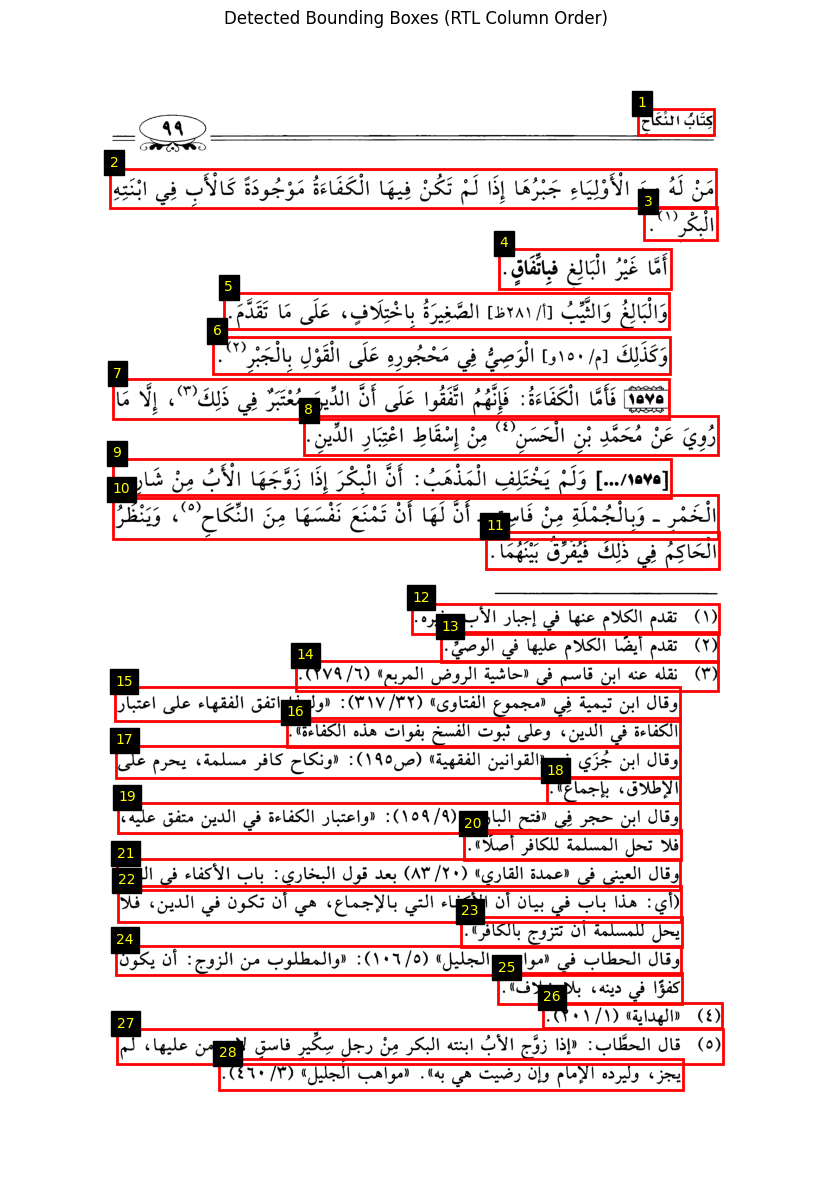

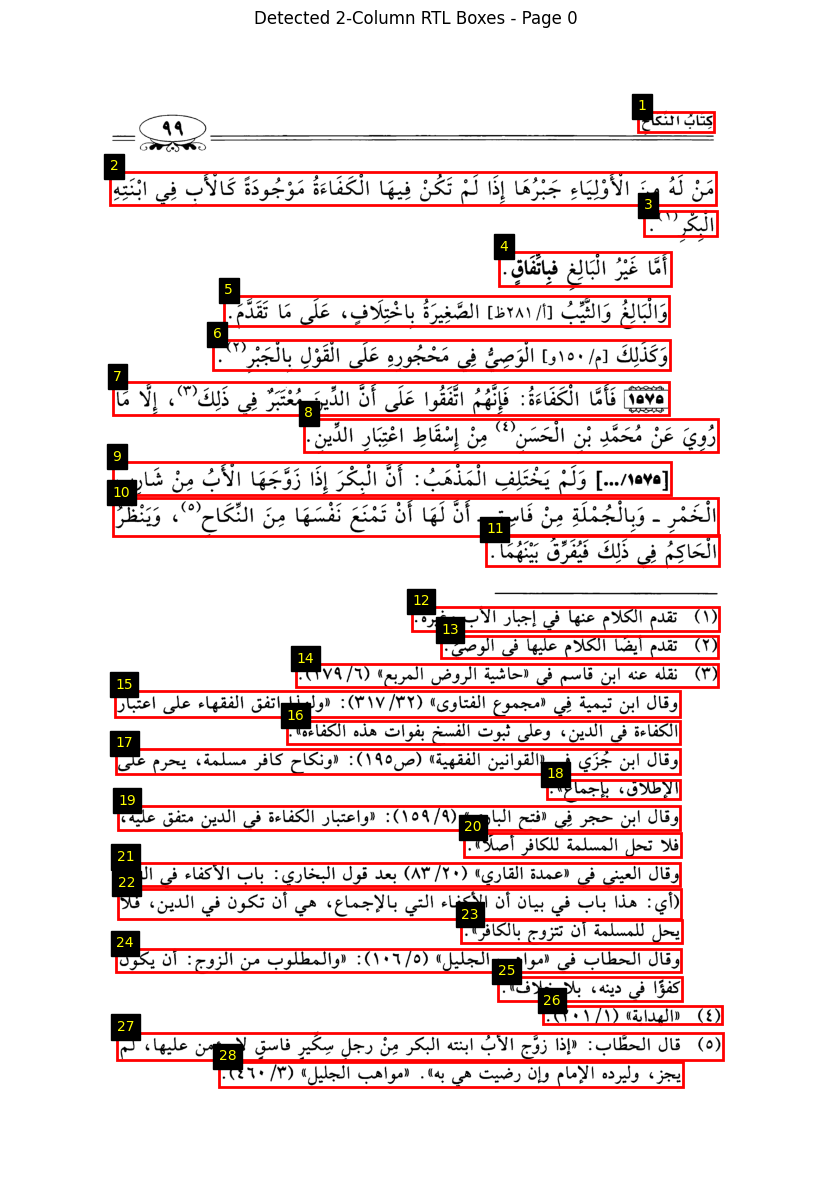

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]s]


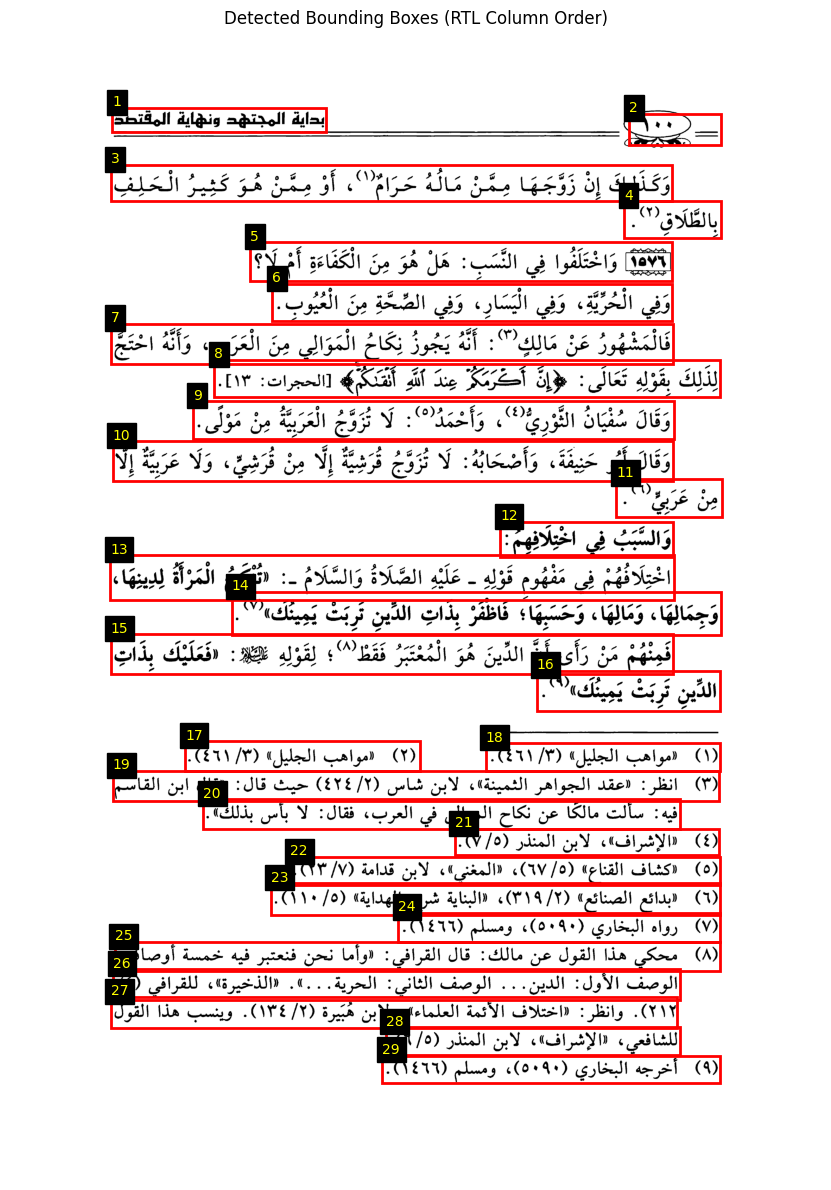

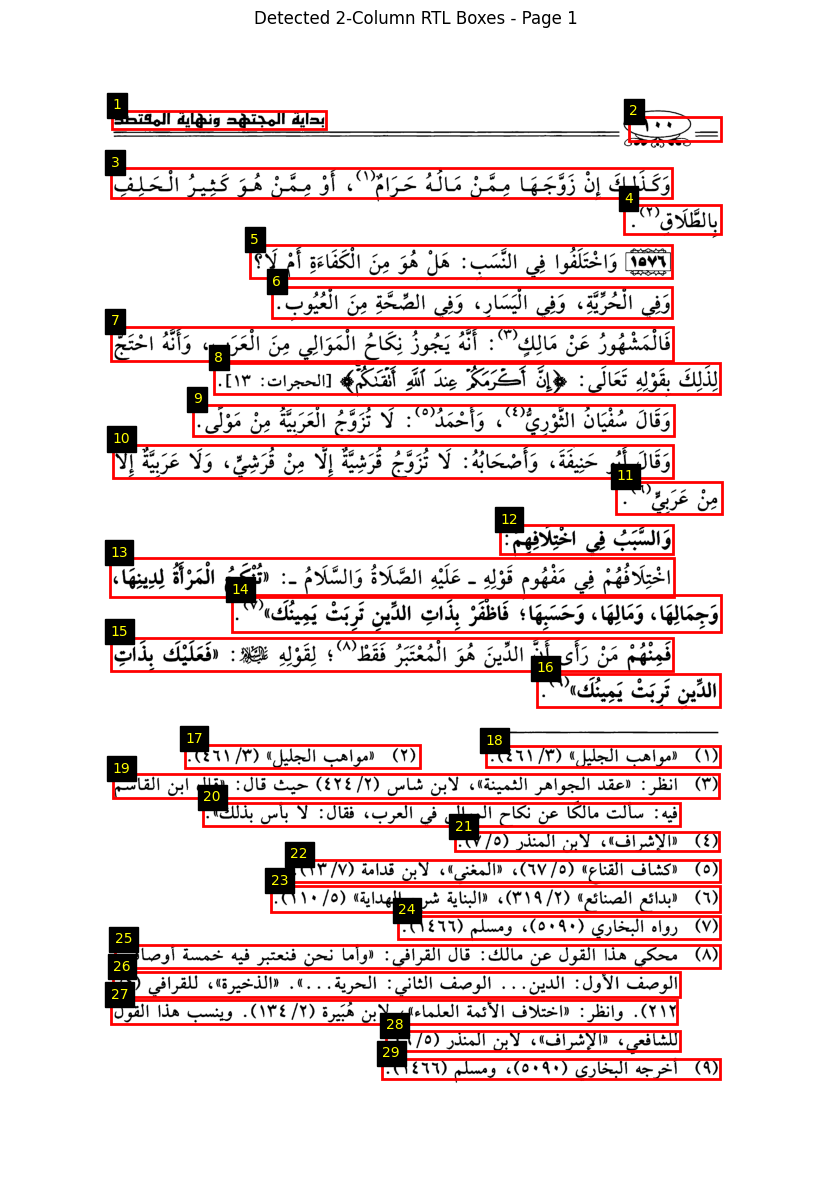

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]s]


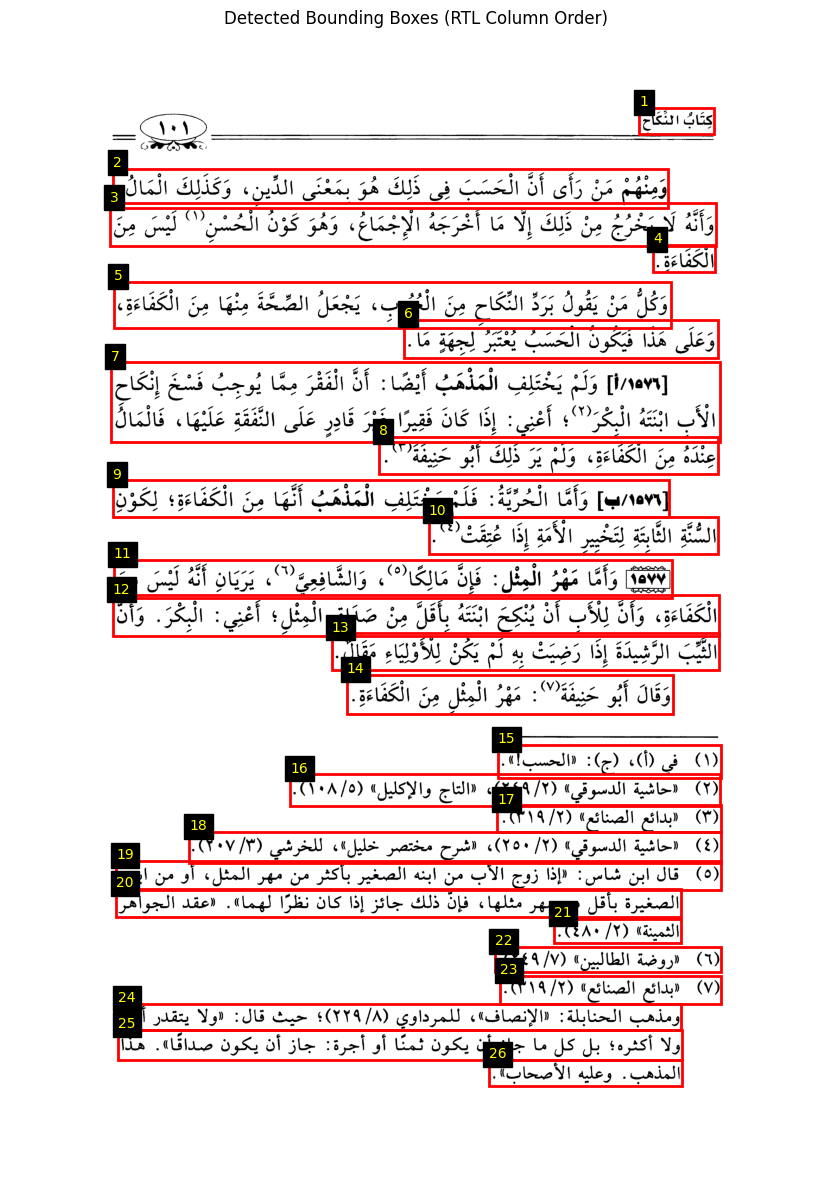

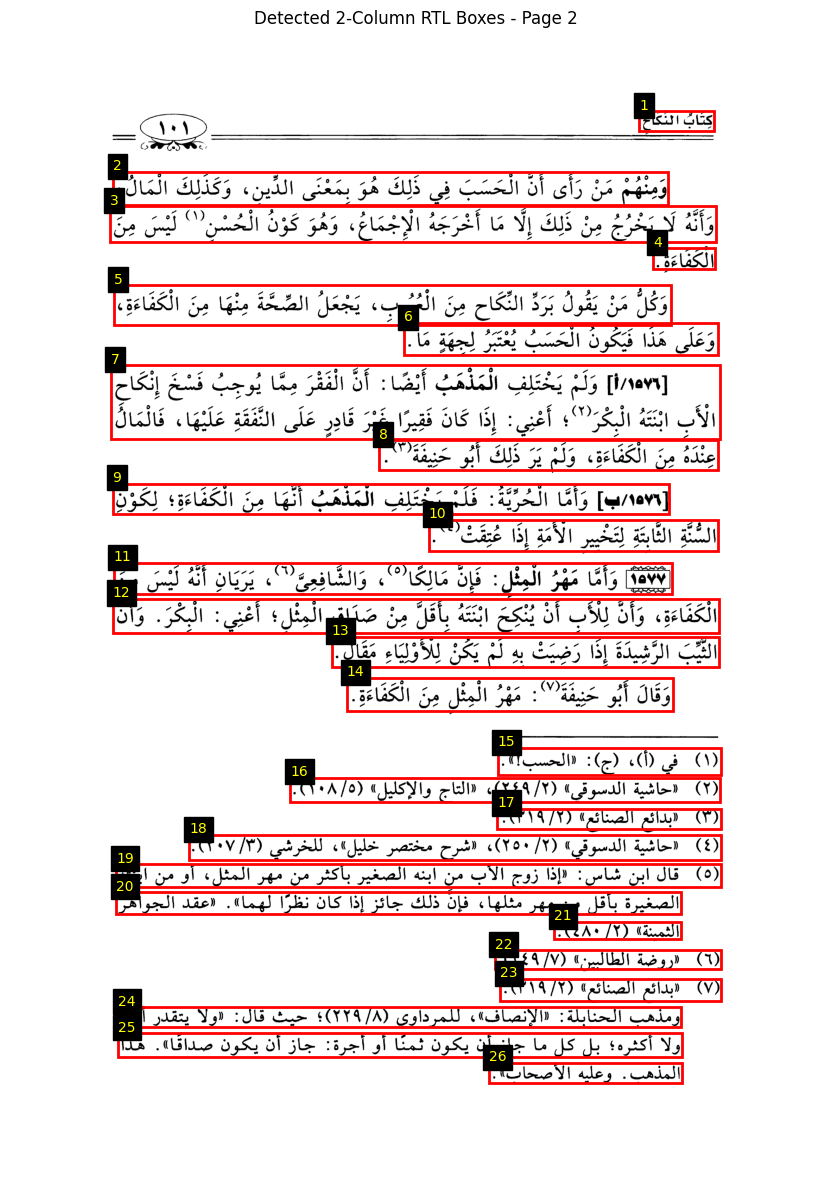

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]s]


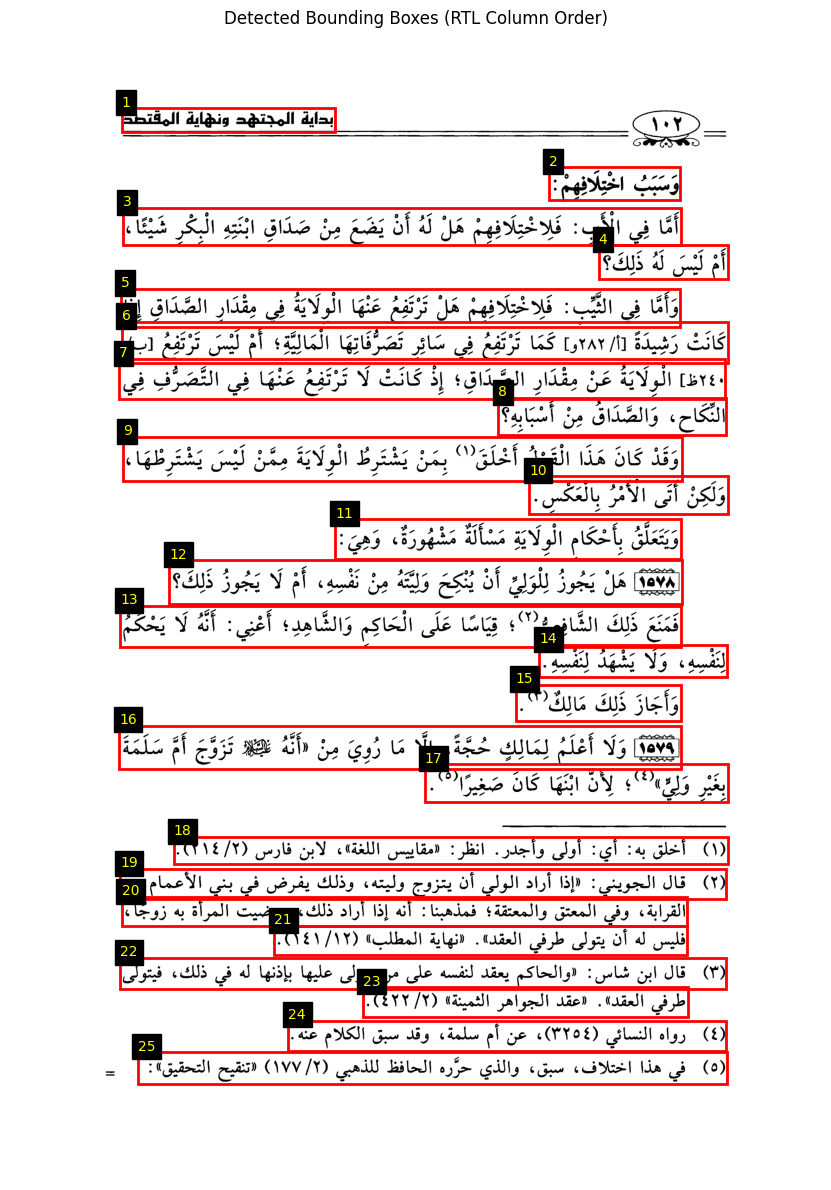

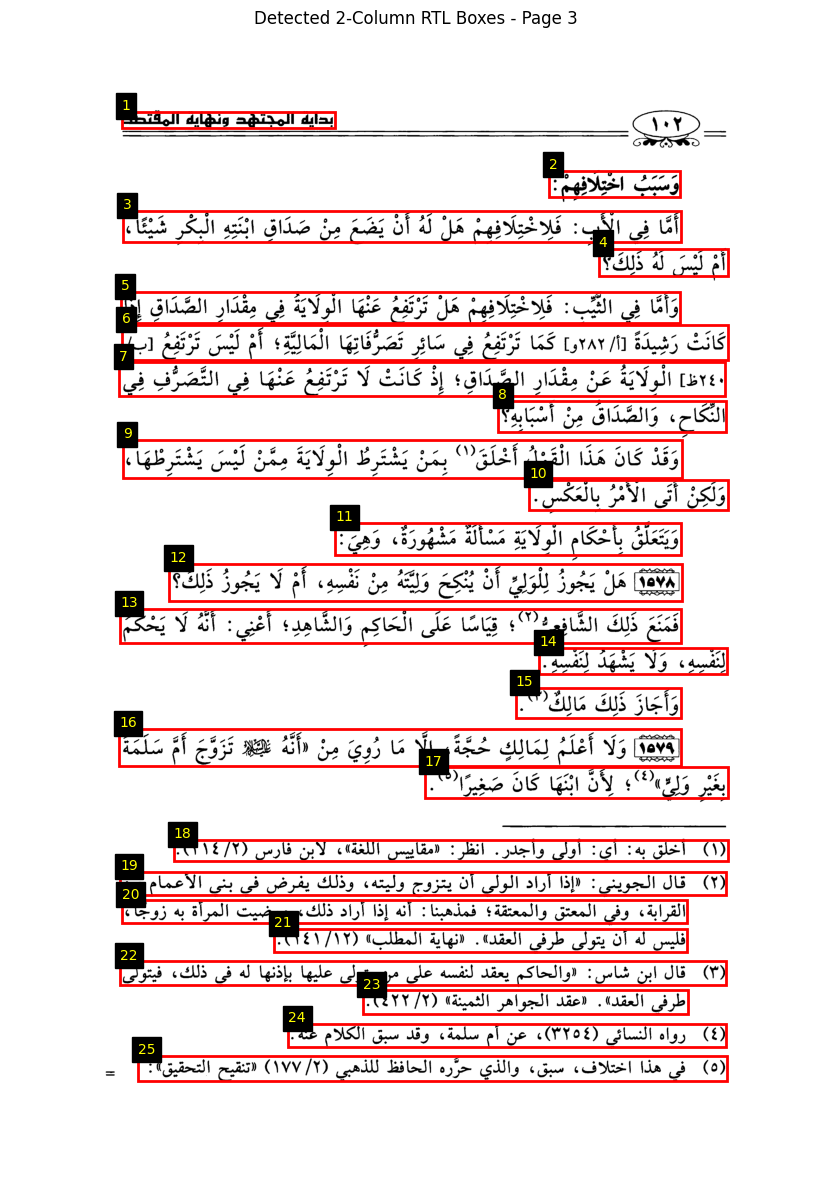

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]s]


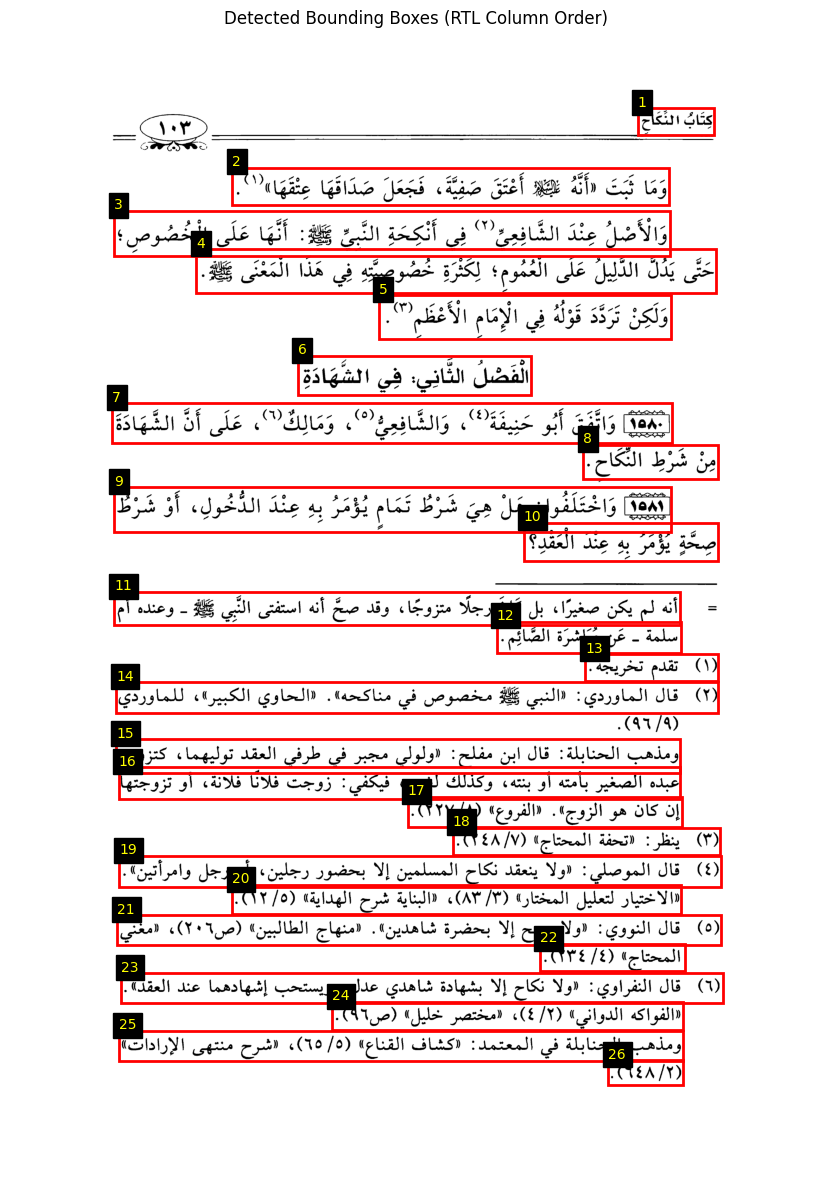

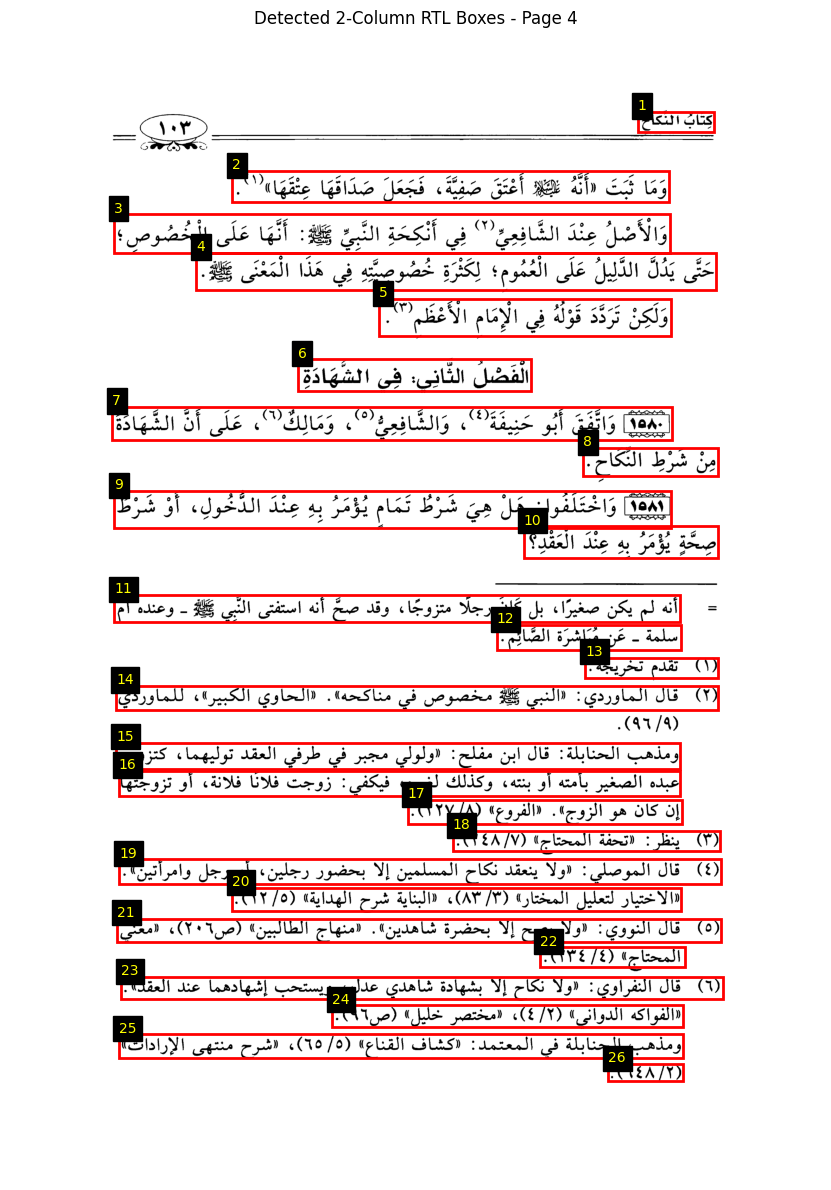

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]s]


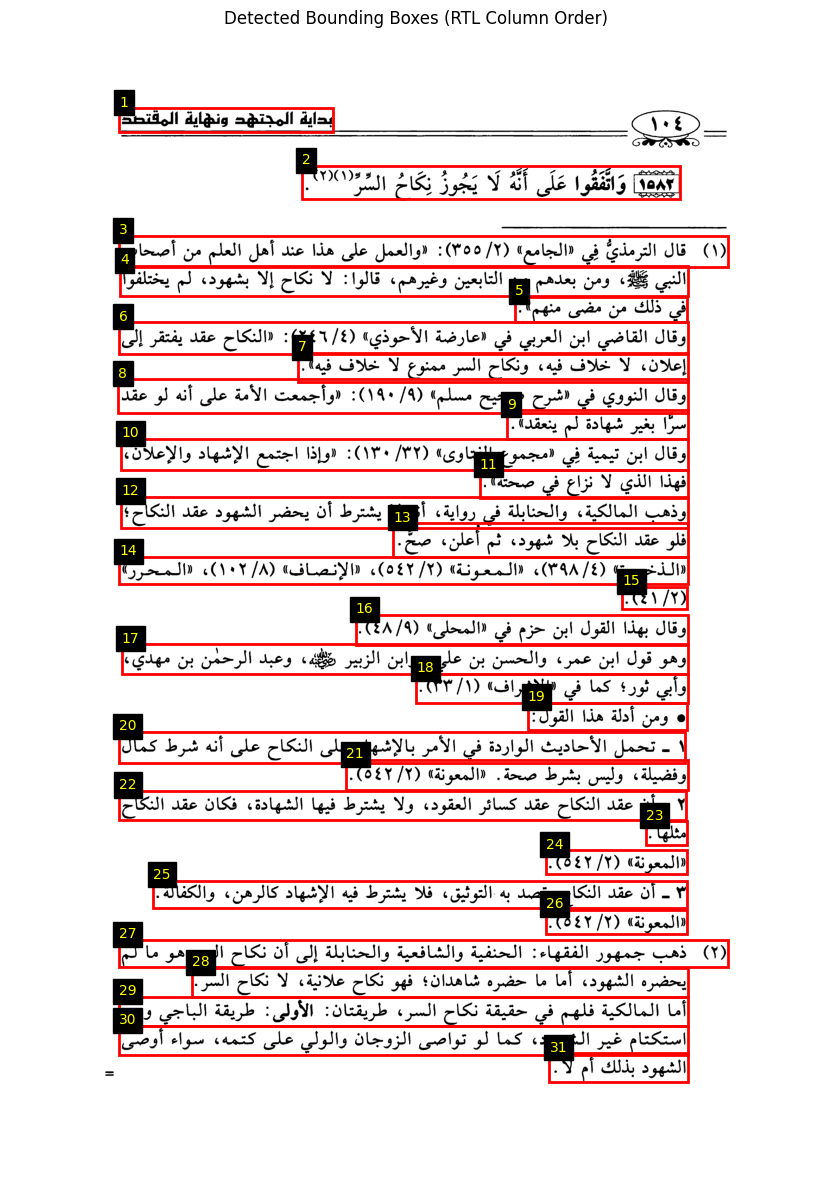

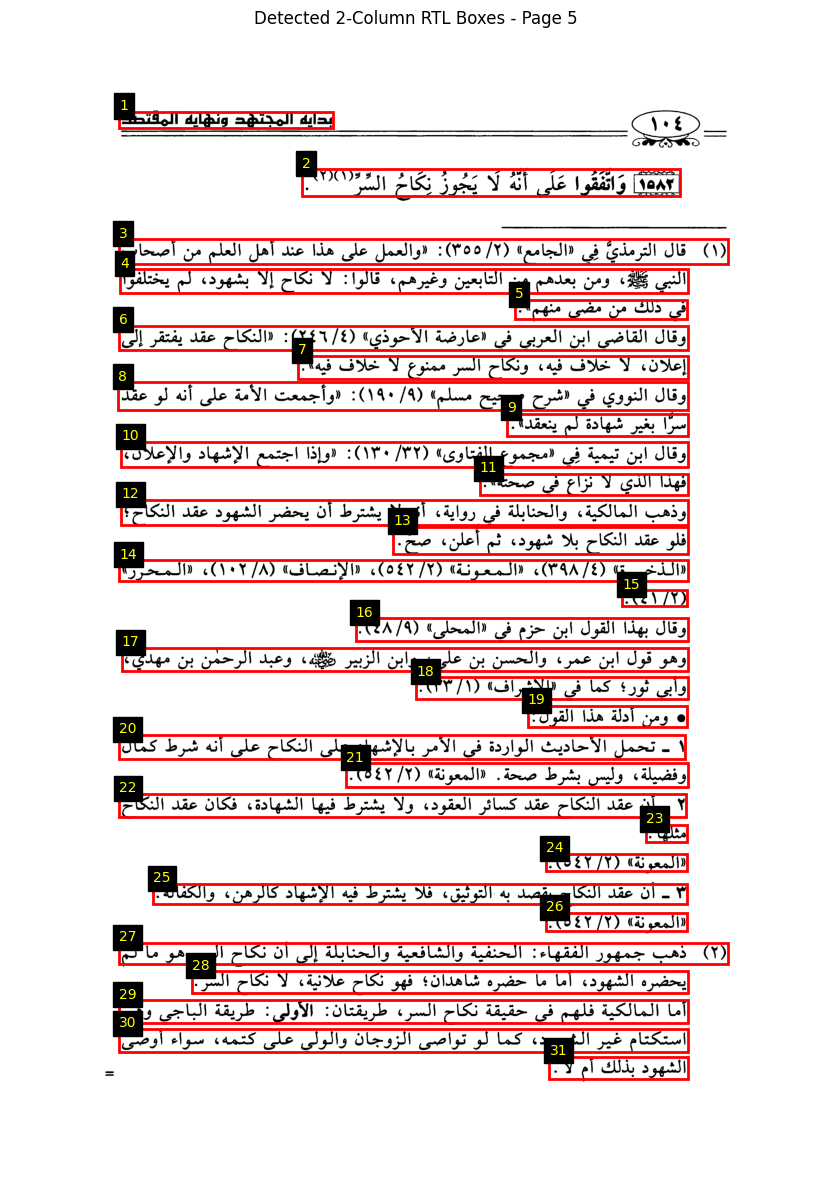

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]s]


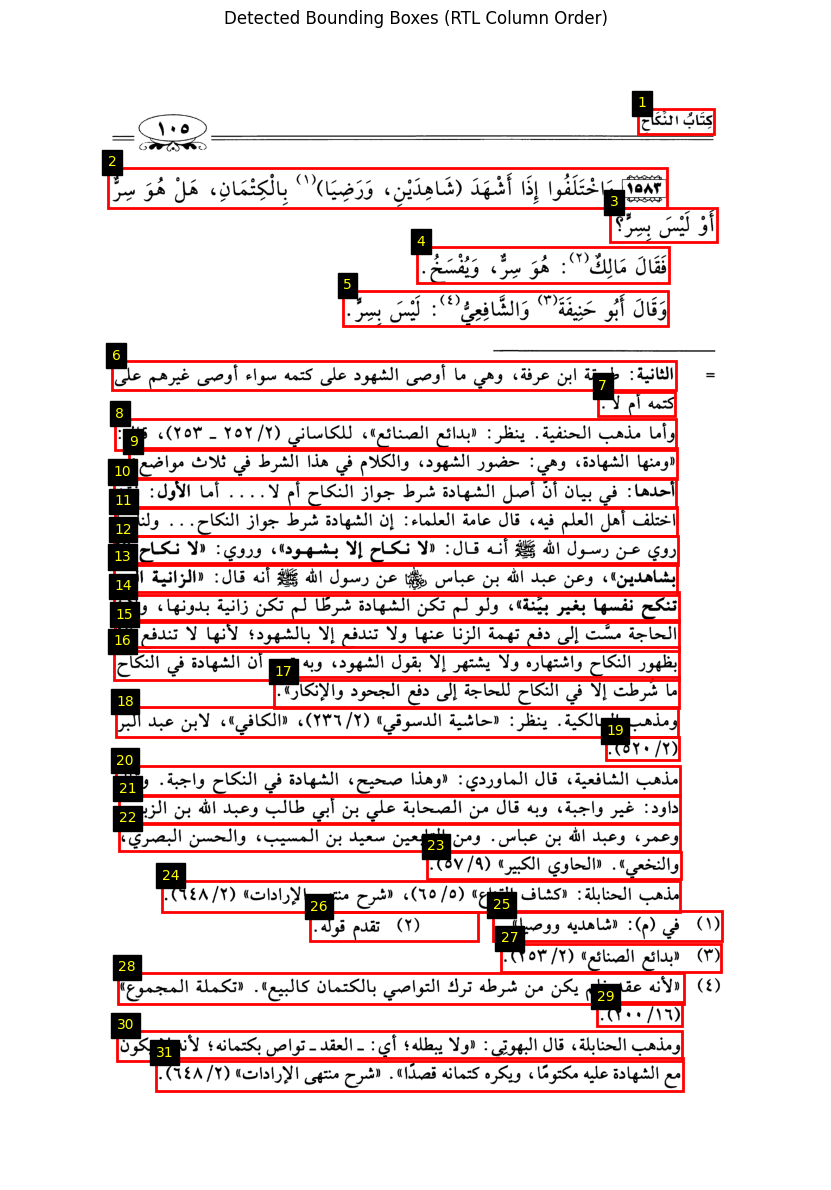

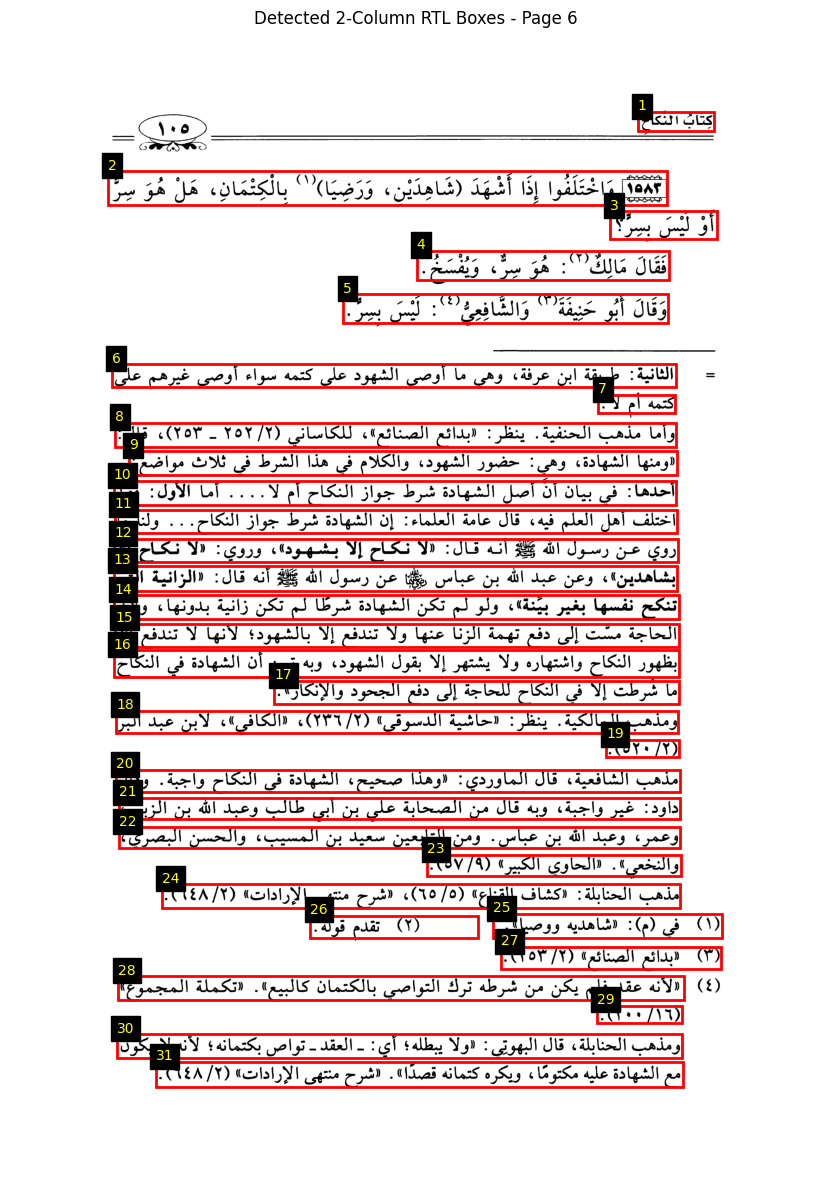

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]s]


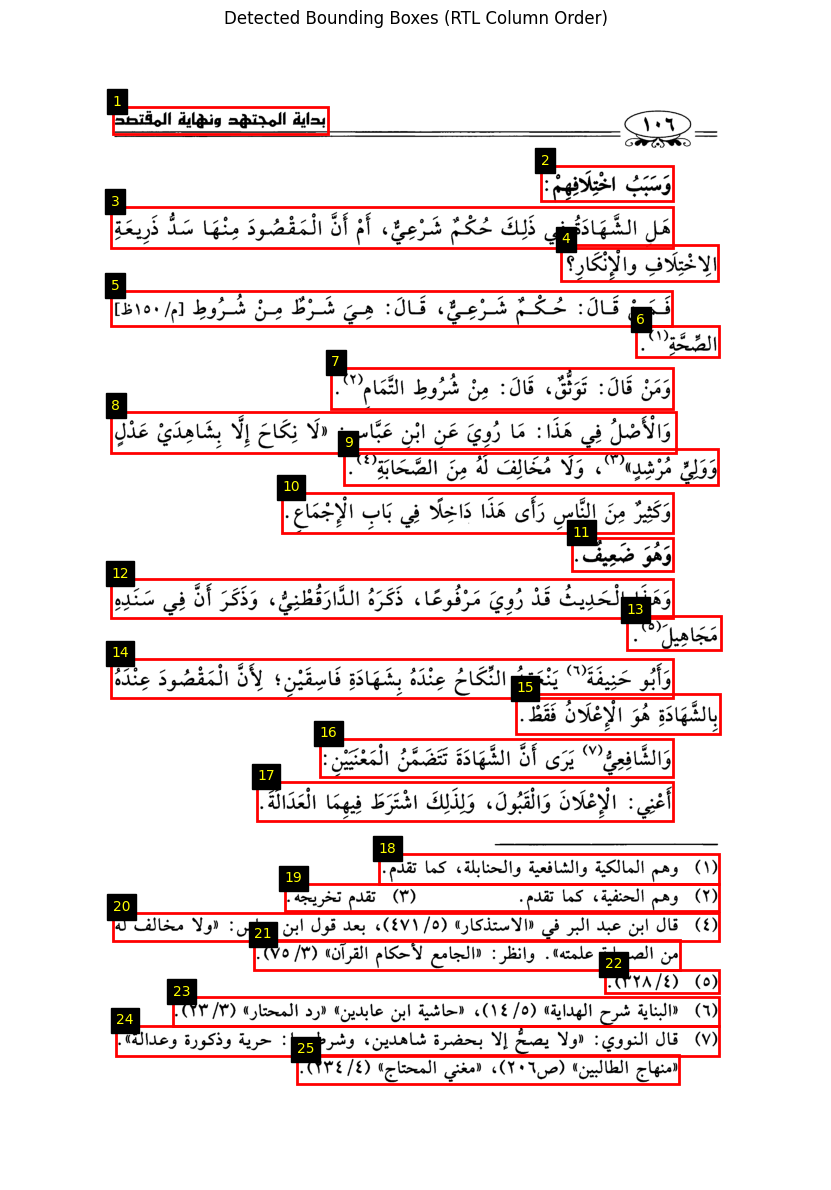

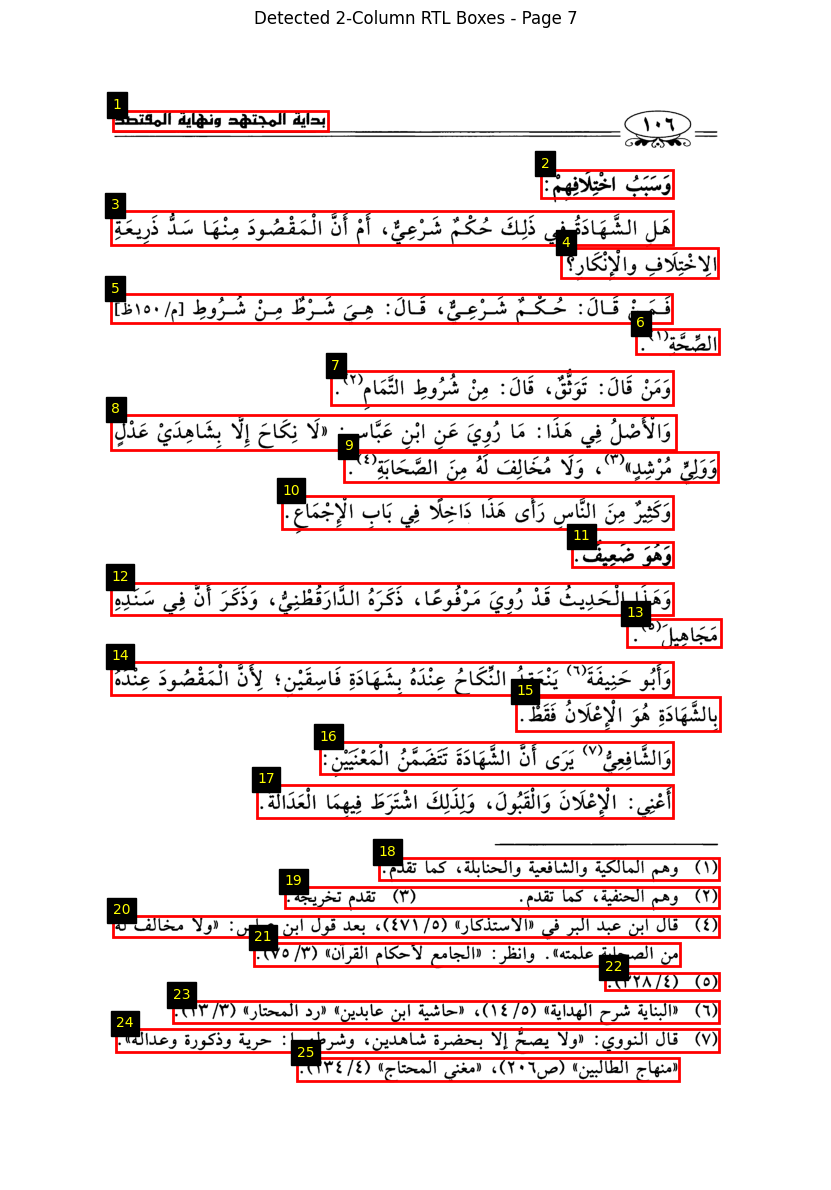

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]s]


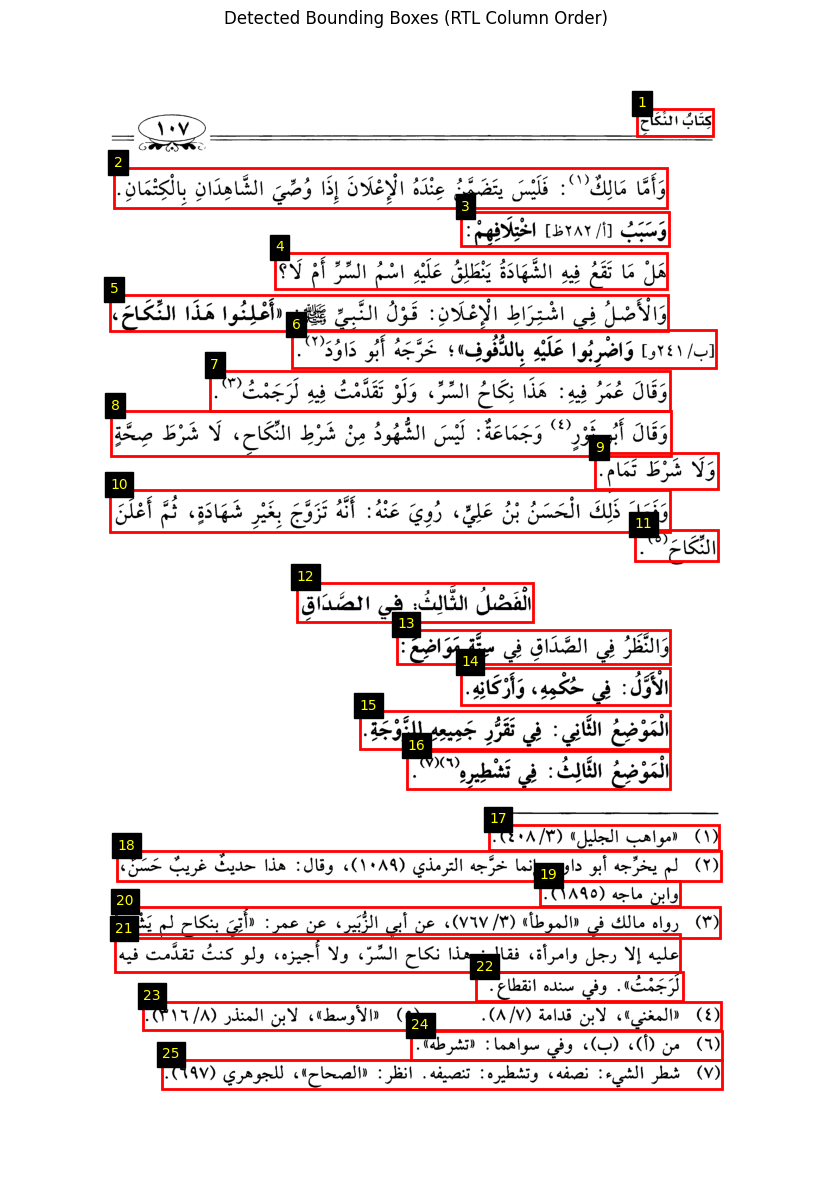

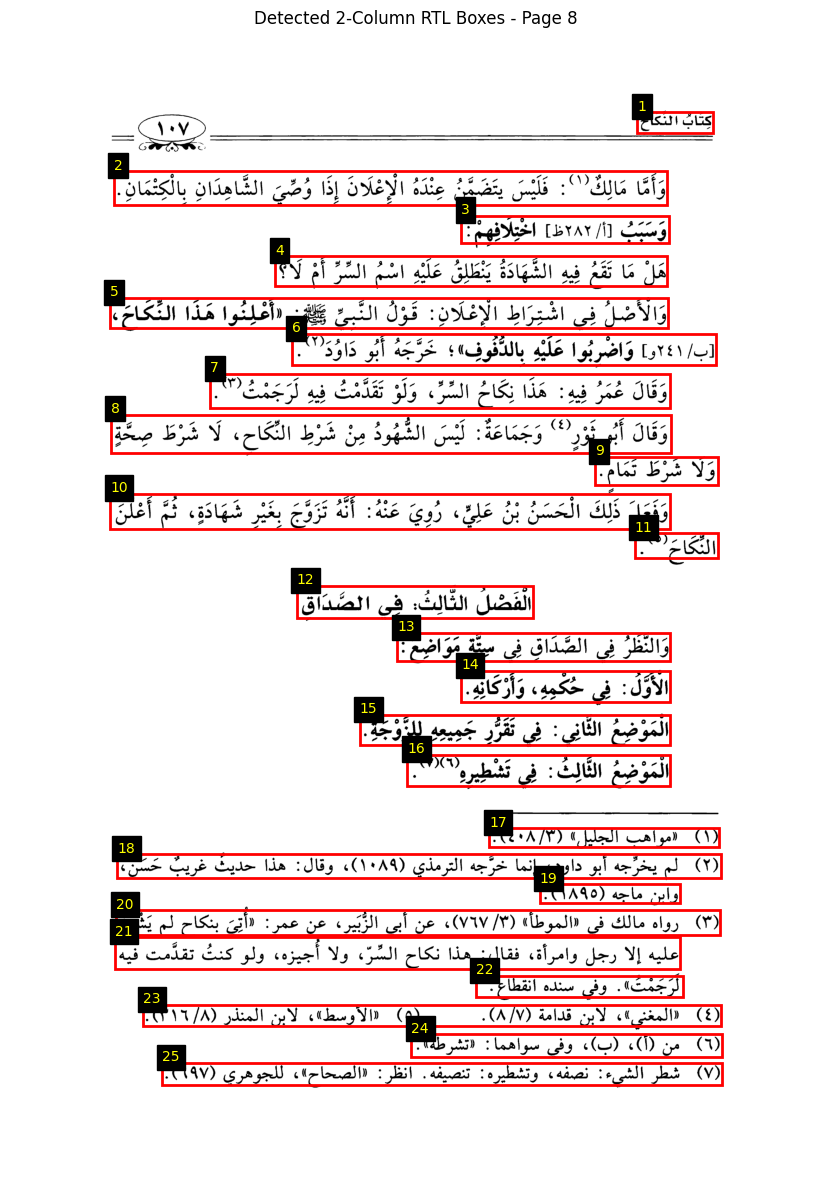

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]s]


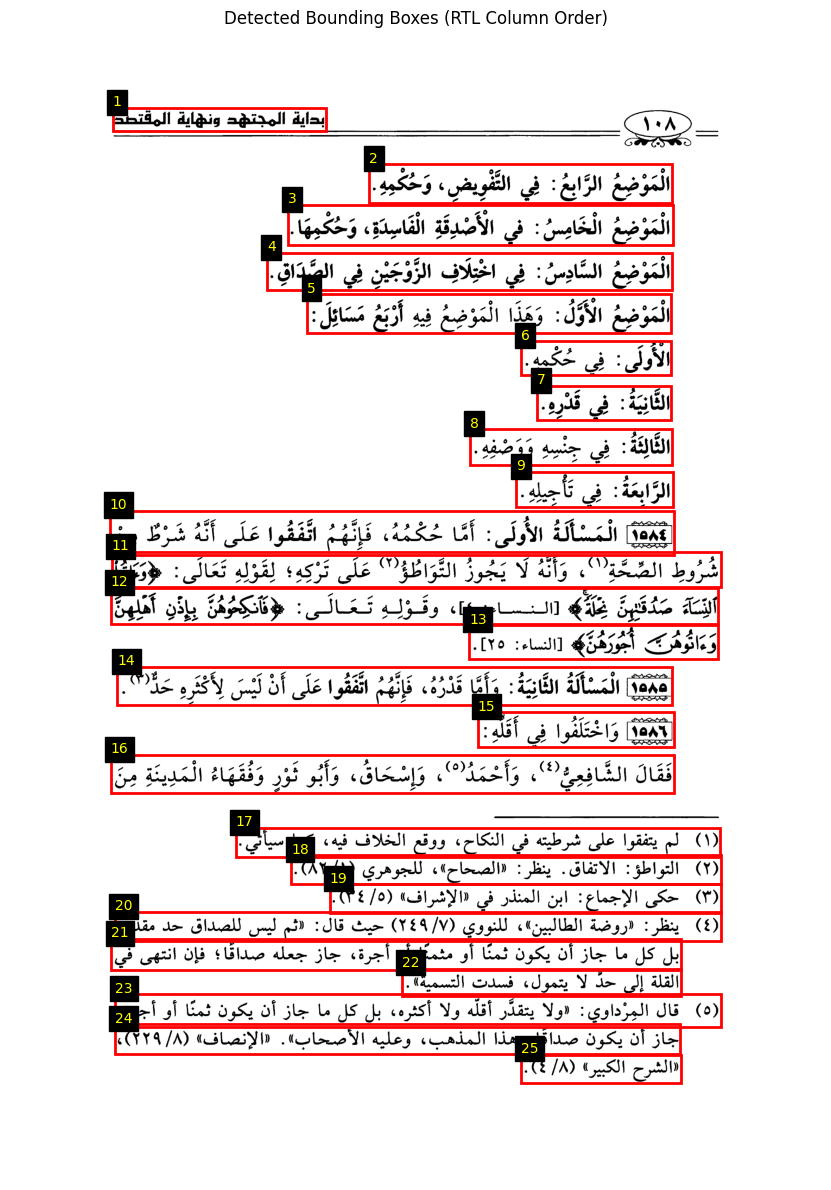

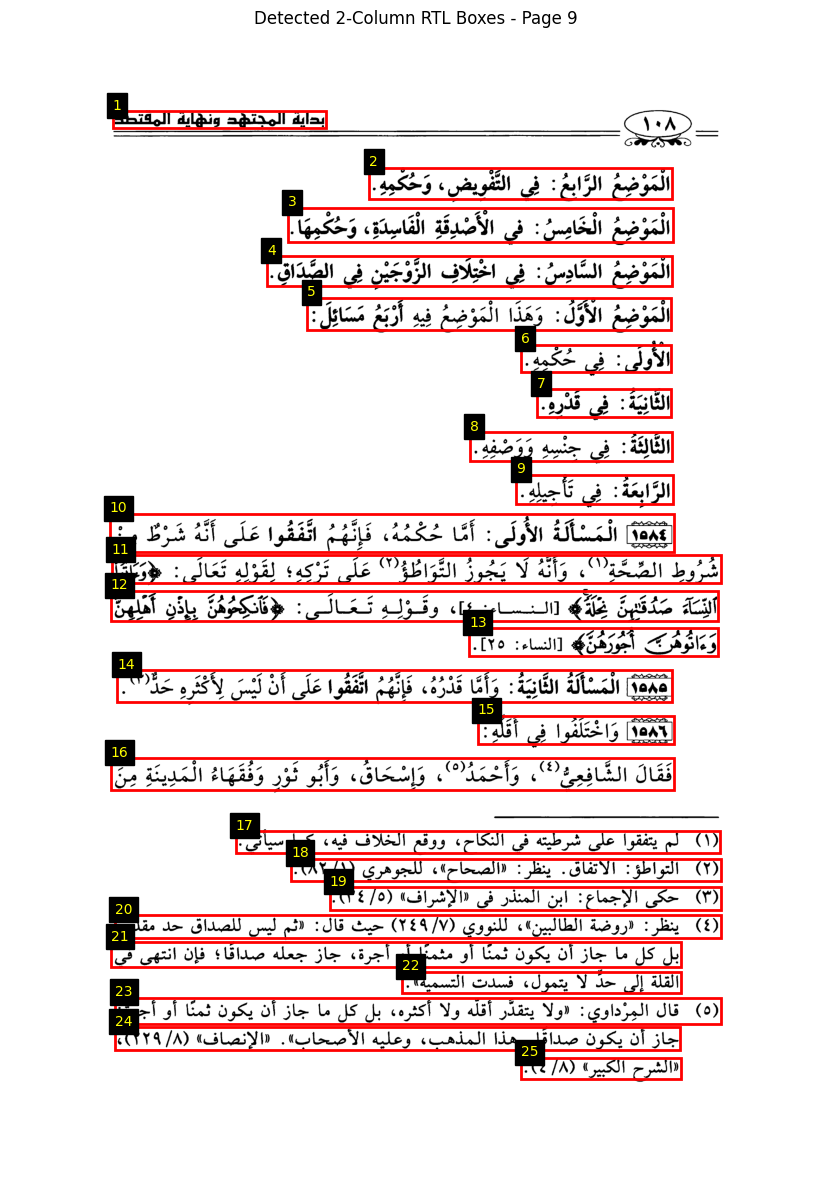

Detecting bboxes: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]/s]


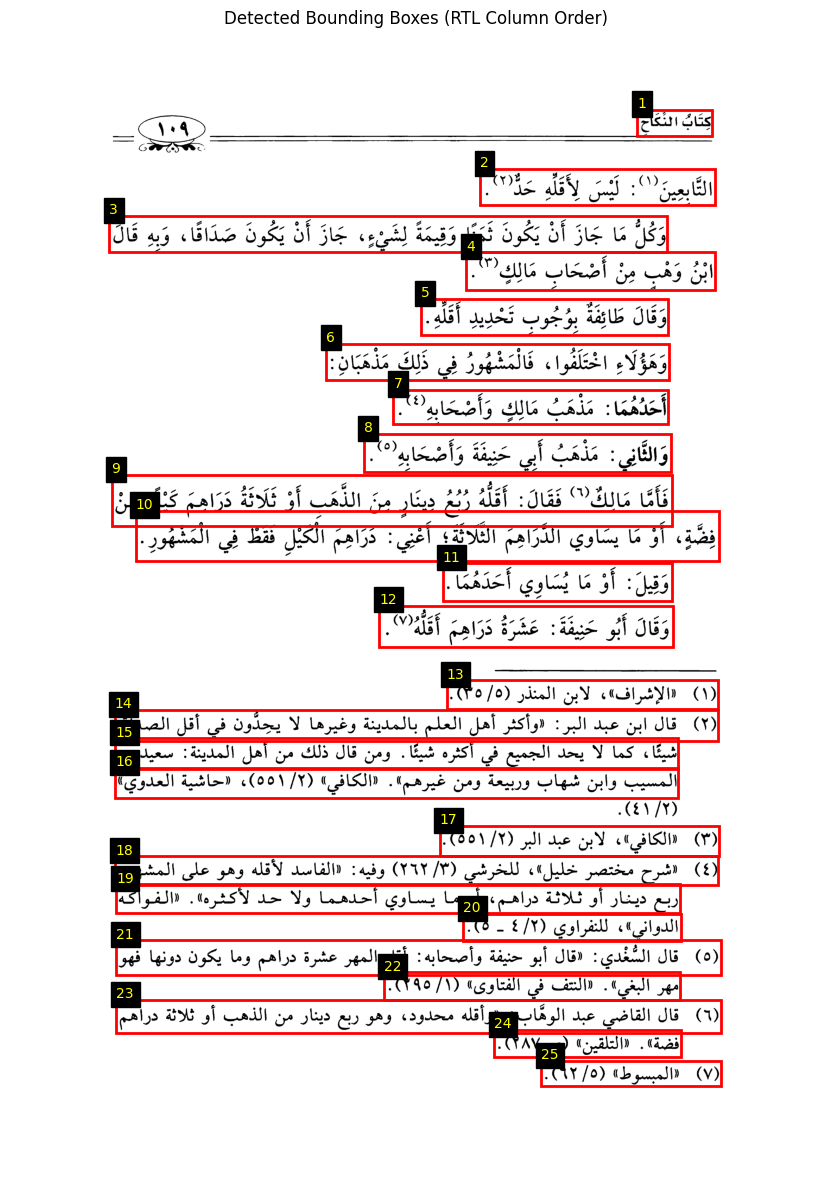

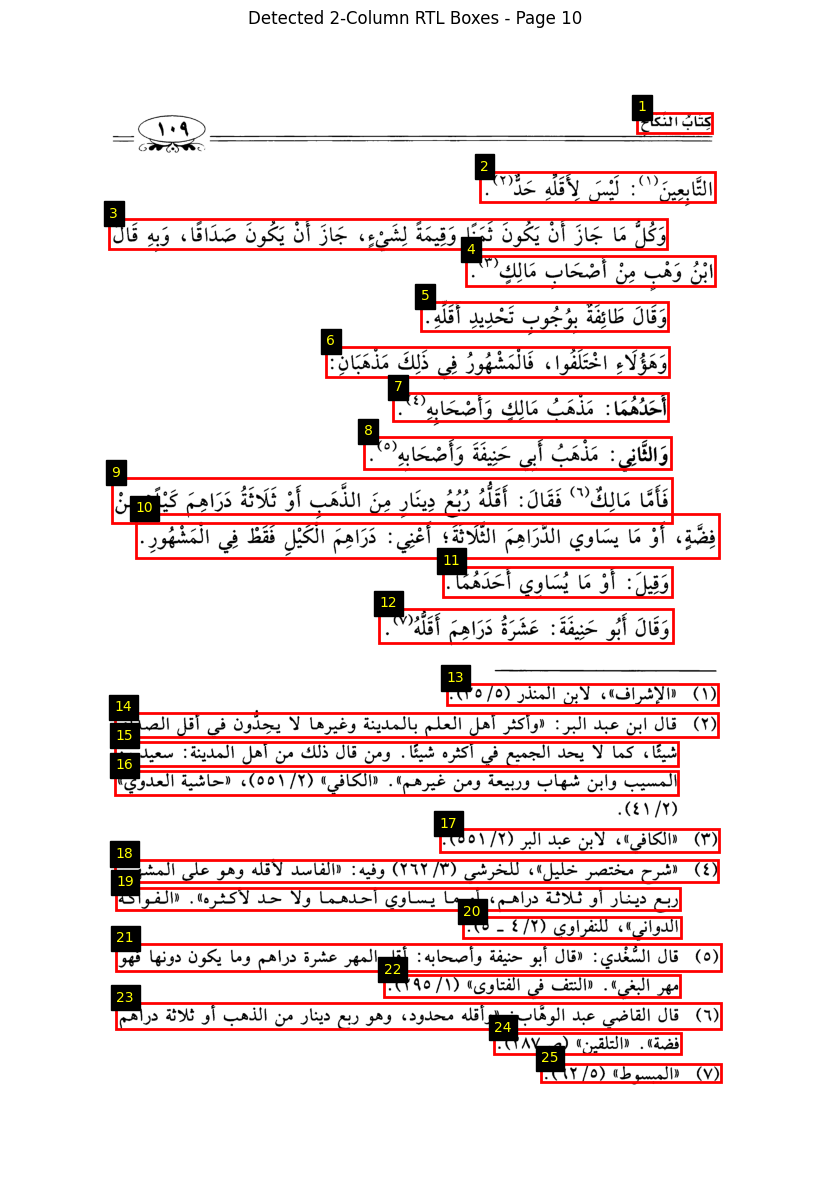

Processing Images: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


In [80]:
#==========================
#  Process all pages
# ==========================
for idx, image in enumerate(tqdm(pages, desc="Processing Images")):
    detection_results = detection_predictor([image])
    det_result = detection_results[0]

    # Filter boxes by confidence
    det_result.bboxes = [b for b in det_result.bboxes if b.confidence >= CONF_THRESHOLD]

    # Route based on layout classification from middle page
    if result['page_orientation'] == 'single_column':
        ordered_bboxes = single_col(det_result.bboxes)
    else:
        ordered_bboxes = two_col(det_result.bboxes)


    # === Visualize ordered boxes ===
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(image)

    for i, bbox in enumerate(ordered_bboxes):
        x1, y1, x2, y2 = map(int, bbox.bbox)

        # Expand vertically
        y1 = max(0, y1 - PADDING_Y)
        y2 = min(image.height, y2 + PADDING_Y)

        # Draw bounding box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{i+1}", color="yellow", fontsize=10, backgroundcolor="black")

    plt.title("Detected Bounding Boxes (RTL Column Order)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Crop regions according to ordered boxes
    cropped_images = []
    for bbox in ordered_bboxes:
        x1, y1, x2, y2 = map(int, bbox.bbox)
        y1 = max(0, y1 - PADDING_Y)
        y2 = min(image.height, y2 + PADDING_Y)
        cropped_region = image.crop((x1, y1, x2, y2))
        cropped_images.append(cropped_region)

    # Store cropped images for this page index in reading order
    book_pages[idx] = cropped_images

    # === Optional visualization ===
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(image)
    for i, bbox in enumerate(ordered_bboxes):
        x1, y1, x2, y2 = map(int, bbox.bbox)
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{i+1}", color="yellow", fontsize=10, backgroundcolor="black")

    plt.title(f"Detected 2-Column RTL Boxes - Page {idx}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
